In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')
import scipy.io as sio
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from pyearth import Earth, export
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filepath = "/Users/xizheng/Documents/florin/respiration/K1/K1_20191226_r0_traces.mat"
Traces = sio.loadmat(filepath)['Traces']

In [3]:
def process_resp(resp):
    windowsize = 15
    resp = resp - np.median(resp)
    resp = -resp
    resp = np.convolve(resp, np.ones(windowsize), 'same') / windowsize
    resp_pks_2, _ = find_peaks(-resp, prominence=0.3, height=0.2, distance=10)
    
    return resp, resp_pks_2

In [4]:
peri_move_sniffs = []

for idx in range(Traces[0,0]['Trial'].shape[1]):
# for idx in range(10):
    
#     print("start analyzing", idx)
    # get data
    resp = Traces[0,0]['Sniffs'][0,idx].flatten()
    trial_on = Traces[0,0]['Trial'][0,idx].flatten()!=0
    if len(resp) == 0:
        print("skipping trial", idx)
        continue
    
    # select region to study
#     trial_off_idx = np.where(trial_on!=0)[0][-1]+1
    trial_off_idx = len(trial_on)
    trial_on = trial_on[:trial_off_idx]
    
    # resp
    resp, resp_pks_2 = process_resp(resp[:trial_off_idx])
    resp_signal = np.zeros(len(resp))
    resp_signal[resp_pks_2] = 1
    
    # lever
    lever = Traces[0,0]['Lever'][0,idx].flatten()
    lever = savgol_filter(lever, 25, 4)
    lever = lever[:trial_off_idx]
    
    pks1, _ = find_peaks(lever, prominence=0.01, distance=5)
    pks2, _ = find_peaks(-lever, prominence=0.01, distance=5)
    peaks = np.concatenate((pks1, pks2))
    peaks = np.sort(peaks)
    
    movement = np.zeros(len(peaks)-1)
    for i in range(len(peaks)-1):
        movement[i] = abs(lever[peaks[i+1]] - lever[peaks[i]])
    movement_signal = np.zeros(len(lever))
    movement_signal[peaks[:-1]] = movement
    large_threshold = 0.8
    
    for start_idx in range(len(peaks)-1):
        if trial_on[peaks[start_idx]] != 0 and movement_signal[peaks[start_idx]] > large_threshold:
            peri_move_sniffs.append(resp_signal[peaks[start_idx]-100:peaks[start_idx]+100])
            
#     plt.figure(figsize=(12,8))
#     plt.plot(lever)
#     plt.plot(movement_signal)
#     plt.plot(np.where(movement_signal>1)[0], lever[np.where(movement_signal>1)[0]], 'or')
#     for i in range(len(resp_pks_2)):
#         plt.axvline(resp_pks_2[i], color='k', linewidth=0.5)
#     plt.plot(5*trial_on)
#     plt.show()
            

skipping trial 0
skipping trial 56


In [5]:
peri_move_sniffs = np.vstack(peri_move_sniffs)


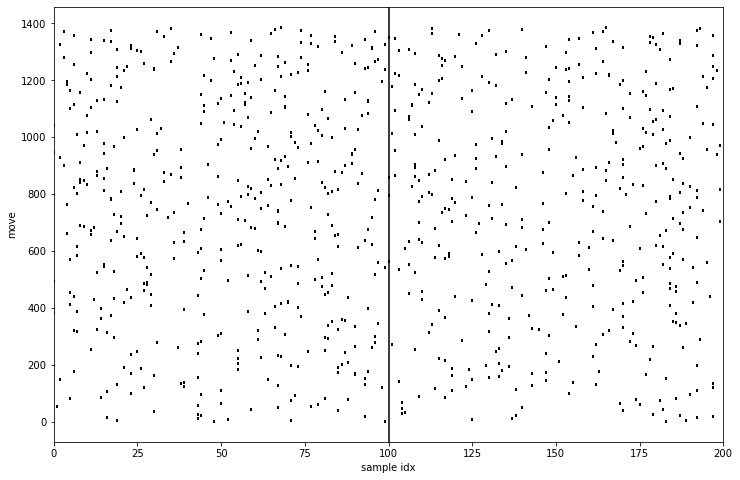

In [6]:
plt.figure(figsize=(12,8))
for i in range(peri_move_sniffs.shape[0]):
    moves = np.where(peri_move_sniffs[i,:] == 1)[0]
    for j in range(len(moves)):
        plt.plot((moves[j], moves[j]), (i, i+1), 'k', linewidth=2)
plt.axvline(100, color='k')
plt.xlabel('sample idx')
plt.ylabel('move')
plt.xlim((0,200))
plt.show()

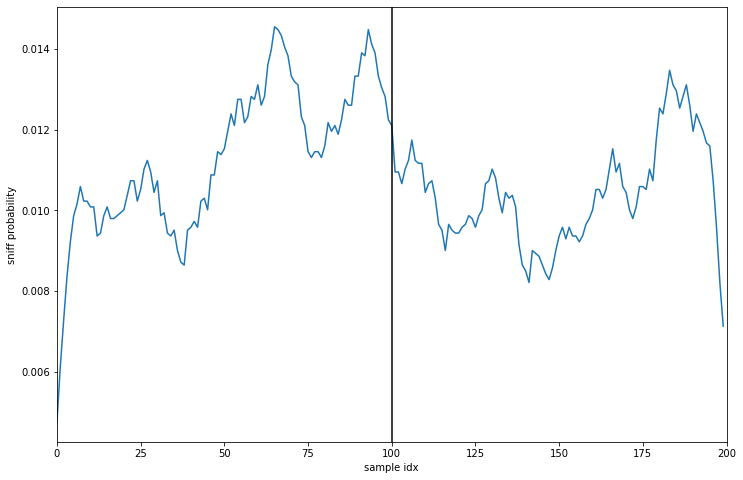

In [7]:
mean_sniffs = np.mean(peri_move_sniffs, axis=0)

plt.figure(figsize=(12,8))
plt.plot(np.convolve(mean_sniffs, np.ones(10)/10, mode='same'))
plt.axvline(100, color='k')
plt.xlabel('sample idx')
plt.ylabel('sniff probability')
plt.xlim((0,200))
plt.show()
